In [1]:
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession

import re
import pandas as pd
    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

23/06/22 00:17:07 WARN Utils: Your hostname, Xinyis-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.201 instead (on interface en0)
23/06/22 00:17:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/22 00:17:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/22 00:17:08 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/06/22 00:17:08 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


/Users/jwang/opt/anaconda3/envs/DDS/lib/python3.10/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
from nasa_transformation import *

# Loading and Parsing Log Dataset

In [3]:
input_file_path = 'data/40MBFile.log'
input_df = spark.read.text(input_file_path)
input_df.take(10)

[Row(value='168.178.113.108 - - [2004-05-18 05:58:48] "GET /Archives/edgar/data/0001439124/000129281422000854/ HTTP/1.0" 500 14101'),
 Row(value='197.154.19.231 - - [2019-09-12 00:33:03] "PUT /Archives/edgar/data/0001129068/000095013122003743/narot19cabsee_0818-1508.htm HTTP/1.0" 404 23637'),
 Row(value='163.4.211.40 - - [2010-04-24 06:34:14] "PUT /Archives/edgar/data/1319616/000120919119019599/0001209191-19-019599-index.htm HTTP/1.0" 200 31769'),
 Row(value='203.56.169.197 - - [2011-08-15 10:57:37] "DELETE /Archives/edgar/data/0001439124/000129281422000790/ HTTP/1.0" 303 56873'),
 Row(value='9.77.249.198 - - [2006-07-18 03:11:42] "POST /Archives/edgar/data/1390098/000121390023023295/0001213900-23-023295.txt HTTP/1.0" 404 13877'),
 Row(value='170.71.241.10 - - [2010-11-24 11:15:38] "POST /Archives/edgar/data/0001326380/000132638023000019/MetaLinks.json HTTP/1.0" 303 38517'),
 Row(value='144.93.178.6 - - [2019-05-06 06:46:48] "DELETE /Archives/edgar/data/0001439124/000129281422000790/ H

In [7]:
ts_pattern2 = r'\[(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})]'

In [17]:
# split the rows to columns
df = split_to_df(input_df, ts_pattern2)
df.show(10, truncate=True)

+---------------+-------------------+------+--------------------+--------+------+------------+
|           host|          timestamp|method|            endpoint|protocol|status|content_size|
+---------------+-------------------+------+--------------------+--------+------+------------+
|168.178.113.108|2004-05-18 05:58:48|   GET|/Archives/edgar/d...|HTTP/1.0|   500|       14101|
| 197.154.19.231|2019-09-12 00:33:03|   PUT|/Archives/edgar/d...|HTTP/1.0|   404|       23637|
|   163.4.211.40|2010-04-24 06:34:14|   PUT|/Archives/edgar/d...|HTTP/1.0|   200|       31769|
| 203.56.169.197|2011-08-15 10:57:37|DELETE|/Archives/edgar/d...|HTTP/1.0|   303|       56873|
|   9.77.249.198|2006-07-18 03:11:42|  POST|/Archives/edgar/d...|HTTP/1.0|   404|       13877|
|  170.71.241.10|2010-11-24 11:15:38|  POST|/Archives/edgar/d...|HTTP/1.0|   303|       38517|
|   144.93.178.6|2019-05-06 06:46:48|DELETE|/Archives/edgar/d...|HTTP/1.0|   303|       36675|
|184.123.181.252|2009-06-29 11:34:15|   GET|/Archi

# Handling Missing Data 

## Count Missing Values

In [18]:
df.columns

['host',
 'timestamp',
 'method',
 'endpoint',
 'protocol',
 'status',
 'content_size']

In [19]:
# count the number of missing values for each column
count_null_col(df).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



# Data Engineering

## Format Timestamp

In [20]:
def format_timestamp1(df):
    udf_parse_time = udf(parse_clf_time)
    df = df.select('*',
            df['timestamp'].cast('timestamp').alias('time')).drop('timestamp')
    return df

In [21]:
# format timpstamp to year-month-date format
df = format_timestamp1(df)
df.show(10, truncate=True)

+---------------+------+--------------------+--------+------+------------+-------------------+
|           host|method|            endpoint|protocol|status|content_size|               time|
+---------------+------+--------------------+--------+------+------------+-------------------+
|168.178.113.108|   GET|/Archives/edgar/d...|HTTP/1.0|   500|       14101|2004-05-18 05:58:48|
| 197.154.19.231|   PUT|/Archives/edgar/d...|HTTP/1.0|   404|       23637|2019-09-12 00:33:03|
|   163.4.211.40|   PUT|/Archives/edgar/d...|HTTP/1.0|   200|       31769|2010-04-24 06:34:14|
| 203.56.169.197|DELETE|/Archives/edgar/d...|HTTP/1.0|   303|       56873|2011-08-15 10:57:37|
|   9.77.249.198|  POST|/Archives/edgar/d...|HTTP/1.0|   404|       13877|2006-07-18 03:11:42|
|  170.71.241.10|  POST|/Archives/edgar/d...|HTTP/1.0|   303|       38517|2010-11-24 11:15:38|
|   144.93.178.6|DELETE|/Archives/edgar/d...|HTTP/1.0|   303|       36675|2019-05-06 06:46:48|
|184.123.181.252|   GET|/Archives/edgar/d...|HTTP/

# Data Analysis 

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import functions as F
%matplotlib inline

## Content Size

In [22]:
content_size_summary_df = df.describe(['content_size'])
content_size_summary_df.toPandas()

,summary,content_size
0,count,299999
1,mean,30025.773582578608
2,stddev,17324.63034668724
3,min,1
4,max,60000


## HTTP Status

23/06/22 00:31:44 WARN CacheManager: Asked to cache already cached data.
+------+-----+
|status|count|
+------+-----+
|200   |42794|
|303   |43071|
|304   |43085|
|403   |42550|
|404   |42909|
|500   |42972|
|502   |42618|
+------+-----+



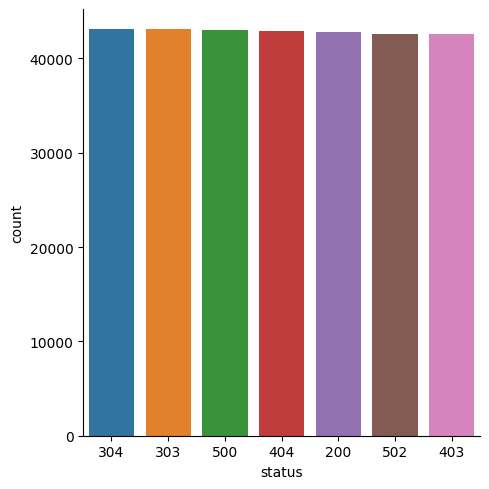

In [28]:
status = plot_status(df)
status.show(truncate=False)

## Frequent Host

In [25]:
top_host(df, 5).show(truncate=False)

+-------------+-----+
|host         |count|
+-------------+-----+
|48.174.91.81 |2    |
|1.121.191.74 |2    |
|201.92.29.248|2    |
|135.3.193.154|2    |
|28.249.24.173|2    |
+-------------+-----+



## Top EndPoint 

In [29]:
top_endpoint(df,10).show(truncate=False)

+-----------------------------------------------------------------------------------+-----+
|endpoint                                                                           |count|
+-----------------------------------------------------------------------------------+-----+
|/Archives/edgar/data/0000205007/000114554923005580/primary_doc.xml                 |2136 |
|/Archives/edgar/data/0001563112/000162828018012499/0001628280-18-012499.txt        |2133 |
|/Archives/edgar/data/0001179929/000117992923000043/moh-20230320_g24.jpg            |2102 |
|/Archives/edgar/data/0001671697/000092963819000390/form10k.htm                     |2098 |
|/Archives/edgar/data/0001002638/000100263815000016/0001002638-15-000016-index.htm  |2098 |
|/Archives/edgar/data/0000205007/000114554923015368/0001145549-23-015368.txt        |2083 |
|/Archives/edgar/data/0001041024/000110465922099664/xslF345X03/tm2225800-4_4seq1.xml|2073 |
|/Archives/edgar/data/0000004281/000119312517062657/R97.htm                     

## Top EndPoints by day of week

In [30]:
result = top_endpoint_by_day(df)
result.show(7, truncate=False)

+---------------------------------------------------------------------------+-----+-------------+
|endpoint                                                                   |count|Day in a week|
+---------------------------------------------------------------------------+-----+-------------+
|/Archives/edgar/data/0000205007/000114554923005580/primary_doc.xml         |337  |Sunday       |
|/Archives/edgar/data/0001563112/000162828018012499/0001628280-18-012499.txt|340  |Monday       |
|/Archives/edgar/data/0000205007/000114554923005577/primary_doc.xml         |340  |Tuesday      |
|/Archives/edgar/data/0001260125/000114420419015093/tv516458_10k.htm        |332  |Wednesday    |
|/Archives/edgar/data/0000101382/000119312517053195/d317189d10k.htm         |323  |Thursday     |
|/Archives/edgar/data/879635/000117184322006367/ownership.xml               |329  |Friday       |
|/Archives/edgar/data/0001179929/000117992923000043/moh-20230320_g27.jpg    |332  |Saturday     |
+-------------------

## 404 status count by day of week

In [32]:
error_by_day = error_count_by_day(df)
error_by_day.show(7, truncate=False)

+-----+-------------+
|count|Day in a week|
+-----+-------------+
|6103 |Sunday       |
|6056 |Monday       |
|6138 |Tuesday      |
|6136 |Wednesday    |
|6229 |Thursday     |
|6212 |Friday       |
|6035 |Saturday     |
+-----+-------------+



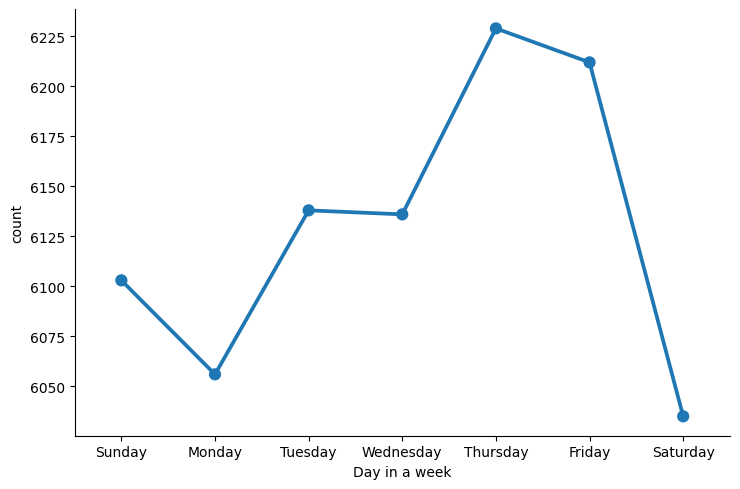

In [33]:
sns.catplot(x='Day in a week', y='count', 
                data=error_by_day.toPandas(), 
                kind='point', height=5, 
                aspect=1.5)